In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Separate cats and dogs (classes 3 and 5)
cats_dogs_train = Subset(train_dataset, [i for i, (_, label) in enumerate(train_dataset) if label in [3, 5]])
cats_dogs_test = Subset(test_dataset, [i for i, (_, label) in enumerate(test_dataset) if label in [3, 5]])


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Separate other classes for autoencoder training
other_classes_train = Subset(train_dataset, [i for i, (_, label) in enumerate(train_dataset) if label not in [3, 5]])

In [17]:
# Function to create subsets and DataLoaders
def create_subset_loader(dataset, fraction, batch_size, shuffle=True):
    subset_size = int(len(dataset) * fraction)
    subset = Subset(dataset, list(range(subset_size)))
    loader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
    return subset, loader

In [18]:
# Create subsets and their loaders
batch_size = 64
half_train_subset, half_train_loader = create_subset_loader(cats_dogs_train, 0.5, batch_size)
third_train_subset, third_train_loader = create_subset_loader(cats_dogs_train, 1/3, batch_size)
quarter_train_subset, quarter_train_loader = create_subset_loader(cats_dogs_train, 0.25, batch_size)

In [5]:
train_loader_cats_dogs = DataLoader(cats_dogs_train, batch_size=batch_size, shuffle=True)
test_loader_cats_dogs = DataLoader(cats_dogs_test, batch_size=batch_size, shuffle=False)
train_loader_other = DataLoader(other_classes_train, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

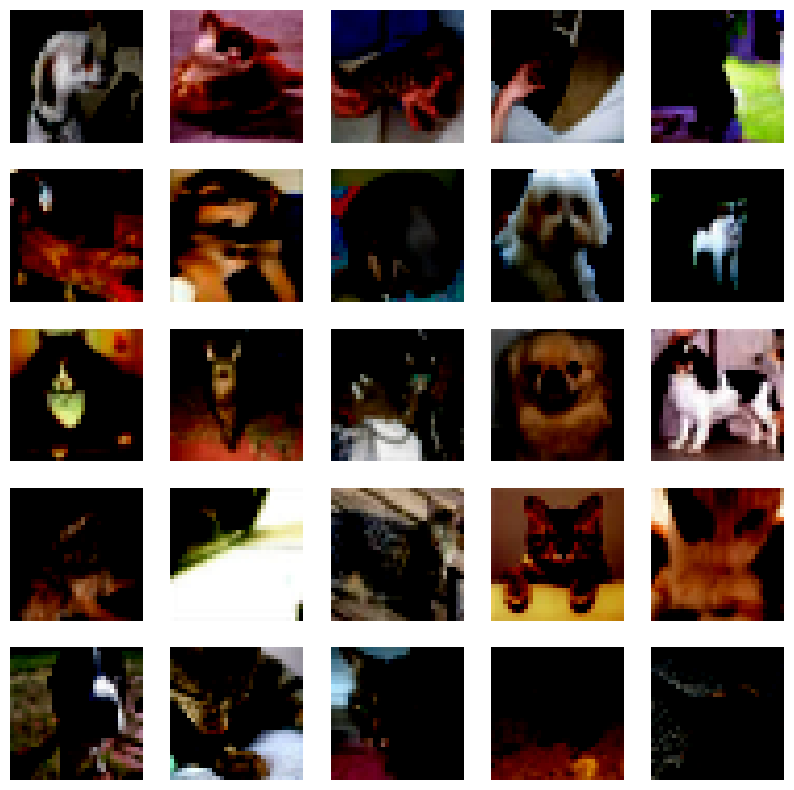

In [7]:
plt.figure(figsize=(10, 10))

for images, _ in train_loader_cats_dogs:
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.axis('off')
    break

In [7]:
print("length of train_loader_cats_dogs", len(train_loader_cats_dogs))
print("length of test_loader_cats_dogs", len(test_loader_cats_dogs))
print("length of train_loader_other", len(train_loader_other))

length of train_loader_cats_dogs 157
length of test_loader_cats_dogs 32
length of train_loader_other 625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

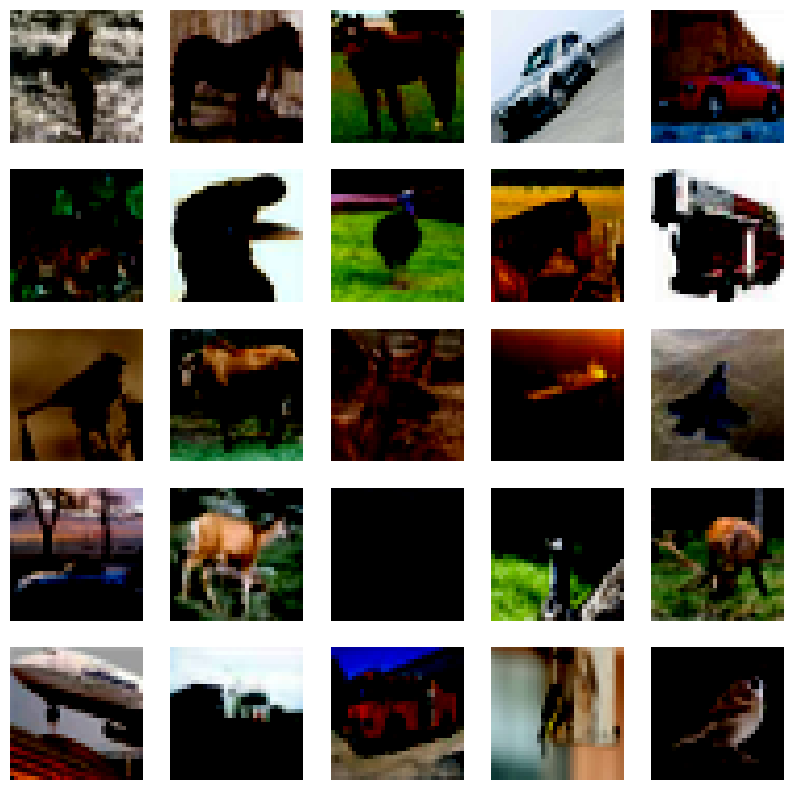

In [6]:
plt.figure(figsize=(10, 10))

for images, _ in train_loader_other:
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.axis('off')
    break

## Reason of this architecture
Since this model's target is to only classify cats and dogs, we simply need two outputs in the output layer. Additionally, the network does not need to be overly complex to prevent overfitting.

In [8]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [34]:
import time

start = time.time()
cnn = BasicCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

# Training loop
def train_model(model, loader, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in loader:
            labels = (labels == 3).long()  # Convert to binary classification (3 = cat, 5 = dog)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(loader)}")

# Train the CNN
train_model(cnn, train_loader_cats_dogs, epochs=30)
print(f"Training time: {time.time() - start}s")


In [35]:
optimizer.zero_grad()
start = time.time()
train_model(cnn, half_train_loader, epochs=30)
print(f"Training time: {time.time() - start}s")

Epoch 1/30, Loss: 0.6870141708398168
Epoch 2/30, Loss: 0.6332254870028435
Epoch 3/30, Loss: 0.5937205092816413
Epoch 4/30, Loss: 0.54582968505123
Epoch 5/30, Loss: 0.5028930989247334
Epoch 6/30, Loss: 0.4691261004043531
Epoch 7/30, Loss: 0.43464276571817034
Epoch 8/30, Loss: 0.381973829073242
Epoch 9/30, Loss: 0.3317422759306582
Epoch 10/30, Loss: 0.27365256468706495
Epoch 11/30, Loss: 0.21391853803320776
Epoch 12/30, Loss: 0.16564555918868584
Epoch 13/30, Loss: 0.13111770987699303
Epoch 14/30, Loss: 0.09238653535707088
Epoch 15/30, Loss: 0.05589734212365709
Epoch 16/30, Loss: 0.03177079352066864
Epoch 17/30, Loss: 0.01752281771041453
Epoch 18/30, Loss: 0.01085501505191662
Epoch 19/30, Loss: 0.005934126955115154
Epoch 20/30, Loss: 0.004047265123057214
Epoch 21/30, Loss: 0.003048382261826928
Epoch 22/30, Loss: 0.002471757066860512
Epoch 23/30, Loss: 0.0020088391913442956
Epoch 24/30, Loss: 0.0017179521463834976
Epoch 25/30, Loss: 0.0014147143346799798
Epoch 26/30, Loss: 0.00123133974170

In [24]:
def test_model(model, loader):
    model.eval()
    correct = 0
    total = 0

    true_positive = 0
    false_positive = 0
    false_negative = 0

    with torch.no_grad():
        for inputs, labels in loader:
            labels = (labels == 3).long()  # Binary classification: 1 if label is cat, 0 otherwise
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update TP, FP, and FN
            true_positive += ((predicted == 1) & (labels == 1)).sum().item()
            false_positive += ((predicted == 1) & (labels == 0)).sum().item()
            false_negative += ((predicted == 0) & (labels == 1)).sum().item()

    # Calculate metrics
    accuracy = correct / total if total > 0 else 0
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")

In [36]:
test_model(cnn, test_loader_cats_dogs)

Accuracy: 0.7245, Recall: 0.7290, Precision: 0.7225


In [9]:
# save the model completely
torch.save(cnn, 'cnn.pth')

## DenoisingAutoencoder Architecture
<img src="DenoisingAutoencoder.png"/>

In [11]:
# refrence: https://www.geeksforgeeks.org/denoising-autoencoders-in-machine-learning/
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [15]:
starttime = time.time()

autoencoder = DenoisingAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
def train_autoencoder(model, loader, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, _ in loader:
            noisy_inputs = inputs + torch.randn_like(inputs) * 0.1
            noisy_inputs = torch.clip(noisy_inputs, 0., 1.)
            optimizer.zero_grad()
            outputs = model(noisy_inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(loader)}")

# Train the autoencoder
train_autoencoder(autoencoder, train_loader_other, epochs=30)

print(f"Training time: {time.time() - starttime}s")

Epoch 1/30, Loss: 0.17776331691741942
Epoch 2/30, Loss: 0.14636632742881775
Epoch 3/30, Loss: 0.1446748145699501
Epoch 4/30, Loss: 0.14382207683324813
Epoch 5/30, Loss: 0.14325561445951462
Epoch 6/30, Loss: 0.1428370237350464
Epoch 7/30, Loss: 0.1425292300581932
Epoch 8/30, Loss: 0.14229036217927932
Epoch 9/30, Loss: 0.14209437276124953
Epoch 10/30, Loss: 0.14192947598695754
Epoch 11/30, Loss: 0.14179128189086915
Epoch 12/30, Loss: 0.14166861256361007
Epoch 13/30, Loss: 0.14156362130641936
Epoch 14/30, Loss: 0.14147547172307967
Epoch 15/30, Loss: 0.1414029003381729
Epoch 16/30, Loss: 0.141330635535717
Epoch 17/30, Loss: 0.14127766436338424
Epoch 18/30, Loss: 0.1412132000207901
Epoch 19/30, Loss: 0.14116733663082123
Epoch 20/30, Loss: 0.14112322472333907
Epoch 21/30, Loss: 0.14108005974292756
Epoch 22/30, Loss: 0.14104162344932555
Epoch 23/30, Loss: 0.1410041933298111
Epoch 24/30, Loss: 0.14098068113327025
Epoch 25/30, Loss: 0.14094574172496796
Epoch 26/30, Loss: 0.14091525307893754
Epo

In [11]:
torch.save(autoencoder, 'autoencoder.pth')

In [19]:
class FineTuneModel(nn.Module):
    def __init__(self, encoder):
        super(FineTuneModel, self).__init__()
        self.encoder = encoder
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.fc_layers(x)
        return x

# Initialize fine-tune model with pre-trained encoder
fine_tune_model = FineTuneModel(autoencoder.encoder)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fine_tune_model.parameters(), lr=0.001)

In [13]:
torch.save(autoencoder, 'autoencoder.pth')

#### train with full dataset

In [21]:
starttime = time.time()
train_model(fine_tune_model, train_loader_cats_dogs, epochs=30)
print(f"Training time: {time.time() - starttime}s")

Epoch 1/30, Loss: 0.11090900414403837
Epoch 2/30, Loss: 0.09519441453087482
Epoch 3/30, Loss: 0.0863196657092613
Epoch 4/30, Loss: 0.07928652495477989
Epoch 5/30, Loss: 0.06431575256524383
Epoch 6/30, Loss: 0.06013395561344305
Epoch 7/30, Loss: 0.04034339386530837
Epoch 8/30, Loss: 0.042034982584986336
Epoch 9/30, Loss: 0.03518947684591648
Epoch 10/30, Loss: 0.03405308948531688
Epoch 11/30, Loss: 0.05023293053007619
Epoch 12/30, Loss: 0.0902946762811796
Epoch 13/30, Loss: 0.06688216490267664
Epoch 14/30, Loss: 0.038606633488563406
Epoch 15/30, Loss: 0.019324264207344715
Epoch 16/30, Loss: 0.010454297654855711
Epoch 17/30, Loss: 0.007415253674584755
Epoch 18/30, Loss: 0.006342029024937314
Epoch 19/30, Loss: 0.006337839931640389
Epoch 20/30, Loss: 0.005922515192743877
Epoch 21/30, Loss: 0.005179694327073481
Epoch 22/30, Loss: 0.004675235713956838
Epoch 23/30, Loss: 0.004753773429806961
Epoch 24/30, Loss: 0.004725734173627215
Epoch 25/30, Loss: 0.00429366991011193
Epoch 26/30, Loss: 0.004

In [26]:
test_model(fine_tune_model, test_loader_cats_dogs)

Accuracy: 0.7270, Recall: 0.7300, Precision: 0.7256


### train model with subsets of dataset

In [28]:
optimizer.zero_grad()

In [29]:
starttime = time.time()
train_model(fine_tune_model, half_train_loader, epochs=30)
print(f"Training time: {time.time() - starttime}s")

Epoch 1/30, Loss: 0.0017311390188354645
Epoch 2/30, Loss: 0.0016953854896592365
Epoch 3/30, Loss: 0.002474570785355504
Epoch 4/30, Loss: 0.0016215481791962852
Epoch 5/30, Loss: 0.0015917577644197795
Epoch 6/30, Loss: 0.0015609615880814985
Epoch 7/30, Loss: 0.001535897736774339
Epoch 8/30, Loss: 0.0015053475169535678
Epoch 9/30, Loss: 0.0014782615628202529
Epoch 10/30, Loss: 0.0014512172672283081
Epoch 11/30, Loss: 0.0014661717009575909
Epoch 12/30, Loss: 0.0014223850352370587
Epoch 13/30, Loss: 0.001388146649033739
Epoch 14/30, Loss: 0.001350531612428589
Epoch 15/30, Loss: 0.001318629453946207
Epoch 16/30, Loss: 0.0012891598413330894
Epoch 17/30, Loss: 0.0012602678796357868
Epoch 18/30, Loss: 0.0012334096601436982
Epoch 19/30, Loss: 0.001205554132451929
Epoch 20/30, Loss: 0.0011791998403617682
Epoch 21/30, Loss: 0.0011590852288083878
Epoch 22/30, Loss: 0.0011418460112105969
Epoch 23/30, Loss: 0.001108251734496915
Epoch 24/30, Loss: 0.001079512340731549
Epoch 25/30, Loss: 0.001051046982

In [31]:
test_model(fine_tune_model, test_loader_cats_dogs)

Accuracy: 0.7260, Recall: 0.7300, Precision: 0.7242


In [32]:
optimizer.zero_grad()
starttime = time.time()
train_model(fine_tune_model, third_train_loader, epochs=30)
print(f"Training time: {time.time() - starttime}s")

test_model(fine_tune_model, test_loader_cats_dogs)

Epoch 1/30, Loss: 0.0010357331963671142
Epoch 2/30, Loss: 0.000941511523208492
Epoch 3/30, Loss: 0.0009095684796002474
Epoch 4/30, Loss: 0.0008895190731840008
Epoch 5/30, Loss: 0.0008709372730595103
Epoch 6/30, Loss: 0.0008532866427574261
Epoch 7/30, Loss: 0.0008362521341449254
Epoch 8/30, Loss: 0.0008204463389797896
Epoch 9/30, Loss: 0.0008051313373831568
Epoch 10/30, Loss: 0.0007893154114719677
Epoch 11/30, Loss: 0.0007742422948261796
Epoch 12/30, Loss: 0.0007595472537979971
Epoch 13/30, Loss: 0.0007443635314079726
Epoch 14/30, Loss: 0.000729764896260469
Epoch 15/30, Loss: 0.0007156509710460701
Epoch 16/30, Loss: 0.000700956470721068
Epoch 17/30, Loss: 0.0006884132029847264
Epoch 18/30, Loss: 0.0006738999136445582
Epoch 19/30, Loss: 0.0006622010413130343
Epoch 20/30, Loss: 0.0006481714406635427
Epoch 21/30, Loss: 0.000635505004264008
Epoch 22/30, Loss: 0.0006218825766103142
Epoch 23/30, Loss: 0.0006098328411373483
Epoch 24/30, Loss: 0.0005973786040655414
Epoch 25/30, Loss: 0.00058581

In [33]:
optimizer.zero_grad()
starttime = time.time()
train_model(fine_tune_model, quarter_train_loader, epochs=30)
print(f"Training time: {time.time() - starttime}s")

test_model(fine_tune_model, test_loader_cats_dogs)

Epoch 1/30, Loss: 0.0003101576567985376
Epoch 2/30, Loss: 0.0003068615608725622
Epoch 3/30, Loss: 0.0003042522405280579
Epoch 4/30, Loss: 0.000301415874491795
Epoch 5/30, Loss: 0.00029801562635611845
Epoch 6/30, Loss: 0.000294835619291689
Epoch 7/30, Loss: 0.0002924102867837064
Epoch 8/30, Loss: 0.0002892068776018775
Epoch 9/30, Loss: 0.0002863450532515799
Epoch 10/30, Loss: 0.00028328100171961525
Epoch 11/30, Loss: 0.00028042964071346433
Epoch 12/30, Loss: 0.00027786051675775524
Epoch 13/30, Loss: 0.0002747290335292973
Epoch 14/30, Loss: 0.0002721863317503903
Epoch 15/30, Loss: 0.0002693437975096913
Epoch 16/30, Loss: 0.00026614065528072215
Epoch 17/30, Loss: 0.00026362868115086257
Epoch 18/30, Loss: 0.00026060514441308415
Epoch 19/30, Loss: 0.00025796049006885367
Epoch 20/30, Loss: 0.00025507503488029213
Epoch 21/30, Loss: 0.00025229582934098714
Epoch 22/30, Loss: 0.0002496196709728338
Epoch 23/30, Loss: 0.00024686405287894787
Epoch 24/30, Loss: 0.0002443946794954854
Epoch 25/30, Los

### Summary Table

| Model               | Dataset Size | Accuracy (%) | Recall (%) | Precision (%) | Training Time (s) |
|---------------------|--------------|--------------|------------|----------------|--------------------|
| **CNN**             | Full         | **76.65**    | 77.10      | 76.41         | **122.11**         |
| **CNN**             | Half         | **72.45**    | 72.90      | 72.25         | **63.70**         |
| Fine-tuned Model    | Full         | 72.70        | 73.00      | 72.56         | 129.41             |
| Fine-tuned Model    | Half         | 72.60        | 73.00      | 72.42         | 63.57              |
| Fine-tuned Model    | Third        | 72.65        | 73.10      | 72.45         | 42.96              |
| Fine-tuned Model    | Quarter      | 72.75        | 73.20      | 72.55         | **32.25**          |

---

#### Conclusion
The fine-tuned model and the CNN model do not show much difference, and one of the reasons for this could be the task itself, as well as the fact that the data is not abundant. Additionally, the CNN architecture is still well-suited for the data. Therefore, we are going to simplify the CNN architecture.

In [37]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Fewer filters
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 16 * 16, 32),  # Smaller fully connected layer
            nn.ReLU(),
            nn.Linear(32, 2)  # Output layer for binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [38]:
import time

start = time.time()
cnn = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

# Training loop
def train_model(model, loader, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in loader:
            labels = (labels == 3).long()  # Convert to binary classification (3 = cat, 5 = dog)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(loader)}")

# Train the CNN
train_model(cnn, train_loader_cats_dogs, epochs=30)
print(f"Training time: {time.time() - start}s")

Epoch 1/30, Loss: 0.642975059284526
Epoch 2/30, Loss: 0.602696880033821
Epoch 3/30, Loss: 0.5709335150992035
Epoch 4/30, Loss: 0.5436983516641484
Epoch 5/30, Loss: 0.5202432009065228
Epoch 6/30, Loss: 0.4901196288455064
Epoch 7/30, Loss: 0.4671480534182992
Epoch 8/30, Loss: 0.4408236349084575
Epoch 9/30, Loss: 0.42200399783386544
Epoch 10/30, Loss: 0.39950370351979686
Epoch 11/30, Loss: 0.3614053108320115
Epoch 12/30, Loss: 0.34127587753876
Epoch 13/30, Loss: 0.32081219829191826
Epoch 14/30, Loss: 0.2909716748318095
Epoch 15/30, Loss: 0.26654157555027375
Epoch 16/30, Loss: 0.2558010178766433
Epoch 17/30, Loss: 0.21952590488704146
Epoch 18/30, Loss: 0.20290383388092564
Epoch 19/30, Loss: 0.18352785749230416
Epoch 20/30, Loss: 0.15753826005443647
Epoch 21/30, Loss: 0.14901013776754876
Epoch 22/30, Loss: 0.1282173786193702
Epoch 23/30, Loss: 0.11001088205653771
Epoch 24/30, Loss: 0.09525107393029389
Epoch 25/30, Loss: 0.08481186042260971
Epoch 26/30, Loss: 0.07017084994133871
Epoch 27/30,

In [39]:
test_model(cnn, test_loader_cats_dogs)

Accuracy: 0.6950, Recall: 0.6670, Precision: 0.7066


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

class SimplifiedDenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(SimplifiedDenoisingAutoencoder, self).__init__()
        
        # Simplified Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Use fewer channels
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        # Simplified Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),  # Decode to original channels
            nn.Sigmoid()  # Use Sigmoid for pixel values [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = SimplifiedDenoisingAutoencoder()
train_autoencoder(autoencoder, train_loader_other, epochs=30)

In [ ]:
autoencoder = torch.load('autoencoder.pth') # ran the model in colab and saved the model

In [49]:
class FineTuneModel(nn.Module):
    def __init__(self, encoder):
        super(FineTuneModel, self).__init__()
        self.encoder = encoder
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.encoder(x)
        # print(x.shape)
        x = self.fc_layers(x)
        return x

# Initialize fine-tune model with pre-trained encoder
fine_tune_model = FineTuneModel(autoencoder.encoder)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fine_tune_model.parameters(), lr=0.001)

#### now the convergence is much faster

In [51]:
start = time.time()
train_model(fine_tune_model, train_loader_cats_dogs, epochs=30)
print(f"Training time: {time.time() - start}s")

Epoch 1/30, Loss: 0.012559940721127828
Epoch 2/30, Loss: 0.009343918908245055
Epoch 3/30, Loss: 0.006536647042698541
Epoch 4/30, Loss: 0.005134302172898819
Epoch 5/30, Loss: 0.004302434446023196
Epoch 6/30, Loss: 0.0036081910225307674
Epoch 7/30, Loss: 0.0030847575565930573
Epoch 8/30, Loss: 0.0027966172839247972
Epoch 9/30, Loss: 0.0024855972473824006
Epoch 10/30, Loss: 0.002126548918643314
Epoch 11/30, Loss: 0.0018143745363173875
Epoch 12/30, Loss: 0.0016739241178977975
Epoch 13/30, Loss: 0.0014777875616241863
Epoch 14/30, Loss: 0.0014171260876201426
Epoch 15/30, Loss: 0.0012235576692882593
Epoch 16/30, Loss: 0.001184799723255976
Epoch 17/30, Loss: 0.0010915490015258622
Epoch 18/30, Loss: 0.000953462262190048
Epoch 19/30, Loss: 0.11052111085414572
Epoch 20/30, Loss: 0.2263239571100967
Epoch 21/30, Loss: 0.06341157985886761
Epoch 22/30, Loss: 0.014963632258201007
Epoch 23/30, Loss: 0.007965422198354343
Epoch 24/30, Loss: 0.00470212345222118
Epoch 25/30, Loss: 0.0036739485529636976
Epo

#### now the accuracy is more different

In [52]:
test_model(fine_tune_model, test_loader_cats_dogs)

Accuracy: 0.7190, Recall: 0.7090, Precision: 0.7235


All models were trained on a MacBook Pro M3 CPU as part of this experiment. The models were intentionally kept as simple as possible, which resulted in test accuracies around 70%. Based on the results, we can conclude that fine-tuning a pretrained model offers notable advantages. Specifically, it requires less data and achieves faster convergence, making it a more efficient approach.